"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [1]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum

[20 62]
[  0  20  62 100]
[[0.71629014 0.15114965 0.32249755]
 [0.9727589  0.16295943 0.89345913]
 [0.90893412 0.65887173 0.20723516]
 [0.29549205 0.21142406 0.69181968]
 [0.0074588  0.97724752 0.42851864]]
(5, 100)


Text(0, 0.5, 'Spikes')

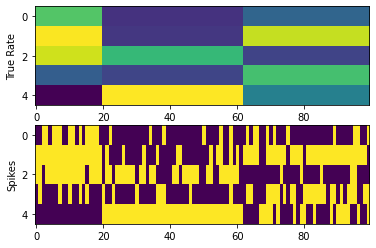

In [217]:
# Some poisson spiking
length = 100
states = 3
nrns = 5
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros((nrns,length))
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
data_vec = np.random.random((nrns,length)) < true_r
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r,aspect='auto')
ax[1].imshow(data_vec,aspect='auto')
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")

In [218]:
def var_sig_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-b*x))

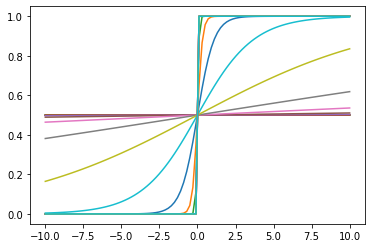

In [219]:
x = np.linspace(-10,10,100)
b_array = np.logspace(-5,5,20)
out = np.stack([var_sig(x,this_b) for this_b in b_array])
plt.plot(x,out.T);

In [220]:
def var_sig_exp_np(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+np.exp(-np.exp(b)*x))

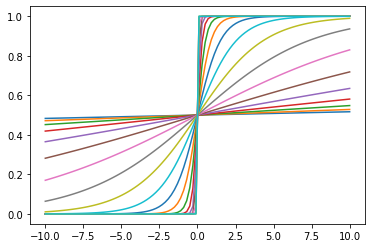

In [221]:
x = np.linspace(-10,10,100)
b_array = np.linspace(-5,5,20)
out = np.stack([var_sig_exp(x,this_b) for this_b in b_array])
plt.plot(x,out.T);

In [222]:
b_array

array([-5.        , -4.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.        ])

In [223]:
mean_vals = np.array([np.mean(x,axis=-1) for x in np.array_split(data_vec,states,axis=-1)]).T
print(mean_vals)

[[0.38235294 0.24242424 0.21212121]
 [0.67647059 0.39393939 0.84848485]
 [0.82352941 0.51515152 0.15151515]
 [0.23529412 0.21212121 0.66666667]
 [0.41176471 0.84848485 0.48484848]]


In [265]:
def var_sig_exp_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-np.exp(b)*x))

def var_sig_tt(x,b):
    """
    x -->
    b -->
    """
    return 1/(1+tt.exp(-b*x))

with pm.Model() as model:
    
    # Same prior for each changepoint
    # Keep 'b' positive so it doesn't flip and get confused with changing lambda
    sig_b = pm.Cauchy('sig_b', 0,2, testval = 0)
    #sig_b = pm.HalfCauchy('sig_b', 20, testval = 0.1) + 0.1
    
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = 2
    b_lambda = 5
    lambda_latent = pm.Beta('lambda', 
                                    a_lambda, b_lambda, 
                                    shape = (nrns,states),
                                  testval = mean_vals + 1e-3)

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [266]:
with model:
    weight_stack = var_sig_exp_tt(idx[np.newaxis,:]-tau[:,np.newaxis], sig_b)
    #weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [267]:
# with model:
#     weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
#     weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
#     inverse_stack = 1 - weight_stack[1:]
#     inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
#     weight_stack = np.multiply(weight_stack,inverse_stack)

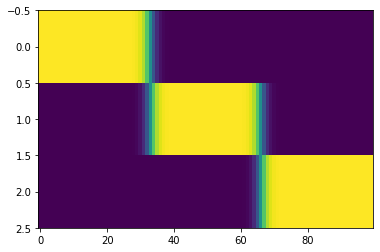

In [268]:
plt.imshow(weight_stack.tag.test_value,aspect='auto')

In [269]:
print(weight_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(3, 100)
(5, 3)


In [270]:
with model:
    lambda_ = lambda_latent.dot(weight_stack)

(5, 100)


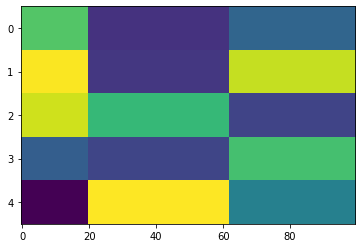

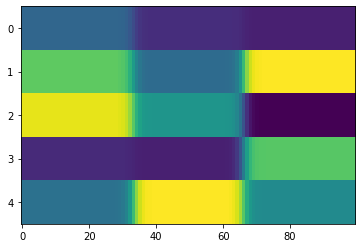

In [271]:
plt.imshow(true_r,aspect='auto')
plt.figure()
plt.imshow(lambda_.tag.test_value, aspect='auto')
print(lambda_.tag.test_value.shape)

In [272]:
with model:
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

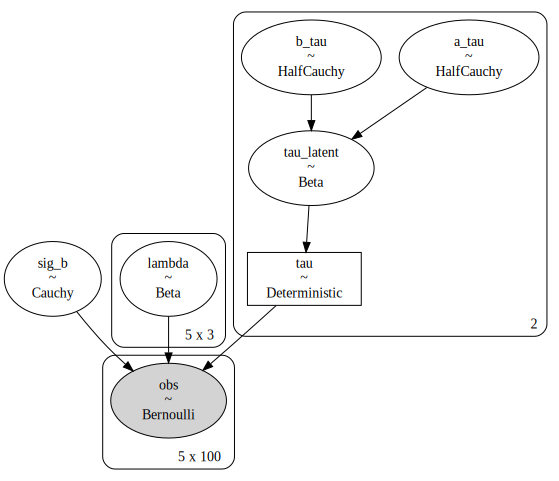

In [273]:
pm.model_to_graphviz(model)

In [274]:
with model:
    advi = pm.ADVI('full-rank')
    tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval,  # callable that returns std
)


In [275]:
advi.approx.mean.eval()

array([ 1.09861229,  1.09861229, -0.47534075, -1.1339969 , -1.30621314,
        0.74217181, -0.42659631,  1.73056635,  1.54734137,  0.06462855,
       -1.71500902, -1.17310545, -1.30621314,  0.69765057, -0.35254787,
        1.73056635, -0.05662118,  0.        , -0.69314718,  0.69314718,
        1.09861229,  1.09861229])

In [276]:
with model:
        approx = pm.fit(n=fit, method=advi,
                   callbacks=[tracker])
        trace = approx.sample(draws=samples)

FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `lambda_logodds__`.ravel()[0] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[1] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[2] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[3] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[4] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[5] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[6] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[7] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[8] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[9] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[10] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[11] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[12] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[13] is NaN.
The current approximation of RV `lambda_logodds__`.ravel()[14] is NaN.
The current approximation of RV `sig_b`.ravel()[0] is NaN.
The current approximation of RV `tau_latent_logodds__`.ravel()[0] is NaN.
The current approximation of RV `tau_latent_logodds__`.ravel()[1] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [277]:
tracker_mean = np.stack(tracker['mean'])
tracker_std = np.stack(tracker['std'])
tracker_mean.shape

(16370, 22)

No handles with labels found to put in legend.


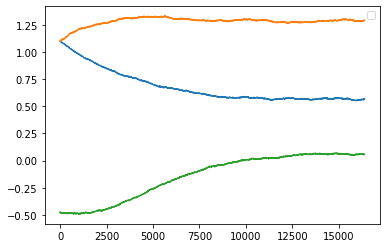

In [278]:
plt.plot(tracker_mean[:,:3]);plt.legend()

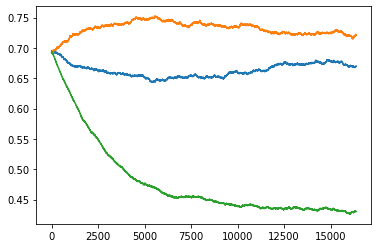

In [279]:
#plt.imshow(tracker_std.T, aspect='auto', interpolation='nearest',origin='lower');
plt.plot(tracker_std[:,:3]);

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [209]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

Text(0.5, 1.0, 'Mean prediction')

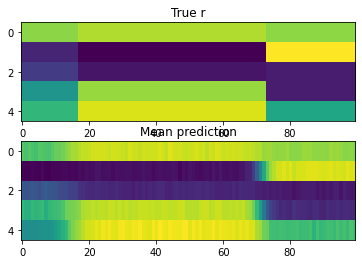

In [210]:
fig,ax = plt.subplots(2,1,sharey=True)
ax[0].imshow(true_r,aspect='auto')
ax[1].imshow(np.mean(ppc['obs'],axis=0), aspect='auto')
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')

In [211]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
mode_tau

(2000, 2)


array([12, 71])

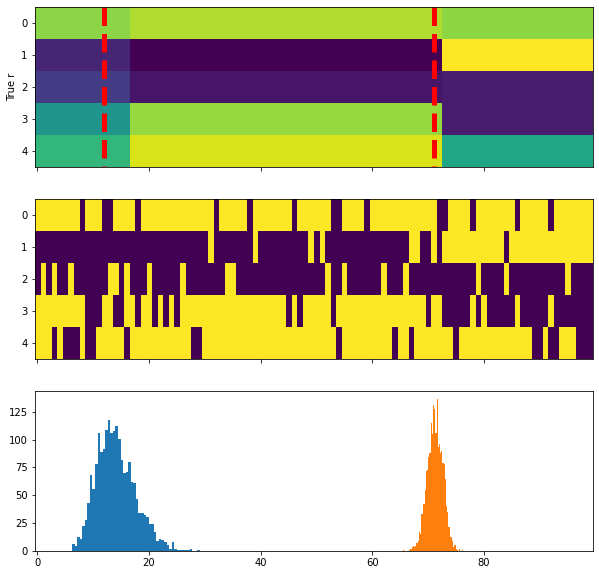

In [212]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].imshow(true_r,aspect='auto')
ax[0].set_ylabel('True r')
ax[1].imshow(data_vec,aspect='auto')
    
for tau_num, this_tau in enumerate(tau.T):
    ax[2].hist(this_tau,bins=50)
    ax[0].vlines(mode_tau[tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')
